# Performance em GPU [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chcomin/curso-visao-computacional-2025/blob/main/M13_desempenho_e_eficiencia/2%20-%20Abordagens%20para%20melhorar%20a%20performance%20(GPU).ipynb)

Veremos algumas estratégias para melhorar a perfomance em GPUs

### Precisão numérica

GPUs modernas realizam operações de forma muito mais eficiente em float16. Mas operações em float16 possuem menor precisão, então é preciso tomar cuidado com a estabilidade numérica dos resultados. Existem algumas abordagens para realizar operações em menor precisão e ao mesmo tempo evitar erros numéricos. 

Compararemos as seguintes situações que possuem diferentes relações custo x precisão:

1. Operações em float64, o que dá o resultado mais preciso possível, mas é menos eficiente
2. Operações em float32, que é o padrão do Pytorch
3. O Pytorch disponibiliza a chamada *automatic mixed precision*. Quando é detectado que uma operação pode ser realizada sem muita perda de precisão, o Pytorch automaticamente realiza a operação em menor precisão. Para isso, é usado o contexto `torch.autocast`
4. Realizar operações em float16, o que é extremamente eficiente em GPUs modernas. Mas é preciso tomar cuidado, por exemplo, não é recomendado realizar o backpropagation em float16
5. Em GPUs recentes o Pytorch possui a função `torch.set_float32_matmul_precision`, que permite o uso de um tipo especial de dado, o chamado *tensorfloat32*. Esse tipo de dado é usado exclusivamente por tensor cores. Ele permite uma precisão próxima de float32 mas com a eficiência de float16

Aplicaremos essas técnicas em multiplicações matriciais

In [3]:
import torch


class PerfRecorder:
    """Registra o tempo de execução na GPU e o uso de memória."""

    def __init__(self):

        self.gpu_start = torch.cuda.Event(enable_timing=True)
        self.gpu_end = torch.cuda.Event(enable_timing=True)  

    def start(self):
        """Inicia registro."""

        torch.cuda.reset_peak_memory_stats()
        self.gpu_start.record() 

    def end(self):
        """Encerra registro."""

        self.gpu_end.record()
        torch.cuda.synchronize()

        # Tempo de execução na GPU, em ms
        t_gpu = self.gpu_start.elapsed_time(self.gpu_end)
        # Uso de memória em GiB
        max_memory = torch.cuda.max_memory_allocated()/2**30
    
        return t_gpu, max_memory
    
def benchmark(shape, dtype, n=5, n_warm=2):
    """Realiza `n` multiplicações matriciais entre matrizes de tamanho
    shape[0]xshape[1] x shape[1]xshape[0]. Retorna o tempo médio de cada 
    multiplicação, a memória utilizada e a média dos valores do resultado."""

    recorder = PerfRecorder()

    nr, nc = shape

    torch.manual_seed(0)
    x1 = torch.randn(nr, nc, dtype=dtype, device="cuda")
    x2 = torch.randn(nc, nr, dtype=dtype, device="cuda")

    for _ in range(n_warm):
        _ = torch.matmul(x1, x2)

    recorder.start()
    for _ in range(n):
        r = torch.matmul(x1, x2)
    t_gpu, max_memory = recorder.end()
    t_gpu /= n

    # Média dos valores do resultado do cálculo
    mean_val = r.abs().mean().item()
    
    return t_gpu, max_memory, mean_val

# Memória disponível na GPU em GiB
mem_size = 12
# Quantidade de valores que podem ser alocados em float64, excluindo 2 GiB para
# evitar problemas de memória
nv = (mem_size-2)*2**30//8
# //2 porque vamos alocar duas matrizes
nv = nv//2
# Tamanho das matrizes. As dimensões terem ao menos tamanho 512 garante que
# a GPU será utilizada ao máximo
mat_shape = (512, nv//512)

In [2]:
# float64
t_f64, m_f64, v_f64 = benchmark(mat_shape, torch.float64)
# float32
t_f32, m_f32, v_f32 = benchmark(mat_shape, torch.float32)
# float16
t_f16, m_f16, v_f16 = benchmark(mat_shape, torch.float16)

print("Tempos (ms):")
print(f"float64: {t_f64:.1f}\nfloat32: {t_f32:.1f}\nfloat16: {t_f16:.1f}")

print("\nMemória (GiB):")
print(f"float64: {m_f64:.1f}\nfloat32: {m_f32:.1f}\nfloat16: {m_f16:.1f}")

print("\nMédia dos valores:")
print(f"float64: {v_f64:.3f}\nfloat32: {v_f32:.3f}\nfloat16: {v_f16:.3f}")

Tempos (ms):
float64: 1260.8
float32: 42.8
float16: 11.1

Memória (GiB):
float64: 10.0
float32: 5.0
float16: 2.5

Média dos valores:
float64: 914.979
float32: 914.738
float16: 912.500


Note as diferenças de tempo. Os cálculos demoram muito mais em float64, e a multiplicação em float16 é mais de 3x mais rápida do que em float32! Isso representa um potencial de speedup de mais de 3x somente modificando a precisão! Mas note que os resultados apresentam pequenas diferenças.

O Pytorch possui duas abordagens para realizar cálculos em meia precisão :

In [3]:
# Autocast para float16, em operações selecionadas. Multiplicação matricial
# é uma dessas operações
with torch.autocast(device_type="cuda", dtype=torch.float16):
    t_af16, m_af16, v_af16 = benchmark(mat_shape, torch.float32)

# Uso do formato tf32 (tensorfloat32) para realizar a multiplicação
torch.set_float32_matmul_precision("high")
t_tf32, m_tf32, v_tf32 = benchmark(mat_shape, torch.float32)

print("Tempos (ms):")
print(f"autocast: {t_af16:.1f}\ntensorfloat32: {t_tf32:.1f}")

print("\nMemória (GiB):")
print(f"autocast: {m_af16:.1f}\ntensorfloat32: {m_tf32:.1f}")

print("\nResultados:")
print(f"autocast: {v_af16:.3f}\ntensorfloat32: {v_tf32:.3f}")

Tempos (ms):
autocast: 21.2
tensorfloat32: 22.2

Memória (GiB):
autocast: 7.5
tensorfloat32: 5.0

Resultados:
autocast: 914.500
tensorfloat32: 914.558


O autocast e o formato tf32 permitem um speedup em relação à float32. 

Há também o formato bfloat32 que possui a mesma magnitude que float32 mas menos resolução. As informações sobre os formatos do Pytorch são:

In [4]:
def pformat(format):
    info = torch.finfo(format)
    print(f"{info.max=}, {info.smallest_normal=}, {info.eps=}")

pformat(torch.float32)
pformat(torch.float16)
pformat(torch.bfloat16)

info.max=3.4028234663852886e+38, info.smallest_normal=1.1754943508222875e-38, info.eps=1.1920928955078125e-07
info.max=65504.0, info.smallest_normal=6.103515625e-05, info.eps=0.0009765625
info.max=3.3895313892515355e+38, info.smallest_normal=1.1754943508222875e-38, info.eps=0.0078125


### Biblioteca bitsandbytes

A biblioteca bitsandbytes possibilita quantizar os parâmetros de camadas lineares, o que reduz o custo de memória.

In [ ]:
import torch.nn as nn
from bitsandbytes.nn import Linear4bit

n = 32
# Modelo em float32
model = nn.Linear(n, n)

# Criação de uma camada Linear4bit e cópia dos pesos do modelo
quantized_model = Linear4bit(n, n)
quantized_model.load_state_dict(model.state_dict())
# O modelo é quantizado ao copiar para a GPU:
quantized_model = quantized_model.to("cuda") 

print(model.weight.numel(), model.weight.dtype)
print(quantized_model.weight.numel(), quantized_model.weight.dtype)

1024 torch.float32
512 torch.uint8


O modelo original com 1024 parâmetros passou a ocupar 512\*8 bits. Isso corresponde a 512\*8/1024 = 4 bits/parâmetro.

In [27]:
print("Primeiros 10 valores do modelo quantizado:")
print(quantized_model.weight[:10])

print("Informação utilizada para recuperar os pesos quando a camada receber uma entrada:")
print(quantized_model.quant_state.as_dict())

Primeiros 10 valores do modelo quantizado:
tensor([[125],
        [115],
        [239],
        [169],
        [179],
        [ 89],
        [ 58],
        [218],
        [217],
        [196]], device='cuda:0', dtype=torch.uint8)
Informação utilizada para recuperar os pesos quando a camada receber uma entrada:
{'quant_type': 'fp4', 'absmax': tensor([206, 181,  51, 204,  94, 194,  54, 200, 212, 204,  23, 213,   0, 195,
         30, 213], device='cuda:0', dtype=torch.uint8), 'blocksize': 64, 'quant_map': tensor([ 0.0000,  0.0052,  0.6667,  1.0000,  0.3333,  0.5000,  0.1667,  0.2500,
         0.0000, -0.0052, -0.6667, -1.0000, -0.3333, -0.5000, -0.1667, -0.2500],
       device='cuda:0'), 'dtype': 'float32', 'shape': (32, 32), 'nested_absmax': tensor([0.0055], device='cuda:0'), 'nested_blocksize': 256, 'nested_quant_map': tensor([-9.9297e-01, -9.7891e-01, -9.6484e-01, -9.5078e-01, -9.3672e-01,
        -9.2266e-01, -9.0859e-01, -8.9453e-01, -8.8047e-01, -8.6641e-01,
        -8.5234e-01, -8.

### Memória *page-locked*

Dados copiados da CPU para a GPU não podem residir em memória pageada, pois a cópia de dados é feita utilizando DMA (Direct Memory Access). Por padrão, um tensor do Pytorch é alocado em memória pageada. É possível criar um tensor em um intervalo de memória não pageada pelo sistema. Esse processo é denominado de "pinned memory", ou page-locked. Ele aumenta de forma significativa o desempenho da cópia dos dados.

In [6]:
def copy(mat_shape, pin):

    recorder = PerfRecorder()

    x = torch.rand(mat_shape)
    if pin:
        x = x.pin_memory()

    recorder.start()
    x = x.to("cuda")
    t_gpu, _ = recorder.end()
    
    return t_gpu

t_nopin = copy(mat_shape, False)
t_pin = copy(mat_shape, True)

print("Tempos (ms):")
print(f"pin=False: {t_nopin:.1f}\npin=True: {t_pin:.1f}")

Tempos (ms):
pin=False: 213.9
pin=True: 108.8


Copiar tensores com pin_memory habilitado é quase 2x mais rápido. Isso é muito relevante, considerando que copiar dados da CPU para a GPU é uma operação extremamente custosa (note que demora mais para copiar uma matriz do que para realizar a multiplicação matricial entre centenas de milhões de valores).

Os dataloaders do Pytorch possuem uma parâmetro `pin_memory` que quando True utiliza essa técnica.

### Checkpoint de gradiente/ativação

Checkpoint de gradiente é uma técnica que permite utilizar menos memória da GPU em troca de um custo computacional um pouco maior. Uma ou mais camadas do modelo são definidas como *checkpoints*. No processamento direto (forward), a ativação de uma camada checkpoint é salva, e as ativações das camadas seguintes não são salvas no grafo de computação. No momento do cálculo de gradientes, as ativações a partir da camada checkpoint são recalculadas.

In [88]:
from torchvision.models import resnet50


def bench_model(model, bs, n=5, n_warm=2):
    """Mede o tempo de execução e uso de memória de um loop de treinamento."""

    optim = torch.optim.SGD(model.parameters())
    x = torch.rand(bs, 3, 224, 224, device="cuda")
    recorder = PerfRecorder()

    for _ in range(n_warm):
        _ = model(x)

    recorder.start()
    for _ in range(n):
        scores = model(x)
        loss = scores.mean()
        loss.backward()
        optim.step()
    t_gpu, max_memory = recorder.end()

    return t_gpu, max_memory

model = resnet50().to("cuda")

t_resnet, m_resnet = bench_model(model, bs=96)
print("Modelo base:")
print(f"Tempo (ms): {t_resnet:.1f}\nMemória (GiB): {m_resnet:.1f}")


Modelo base:
Tempo (ms): 955.8
Memória (GiB): 8.2


In [89]:
from torch import nn
from torch.utils.checkpoint import checkpoint


class ResNetChkp(nn.Module):
    """Cria um modelo ResNet utilizando a técnica de checkpoint de gradiente."""

    def __init__(self, model):
        super().__init__()

        # Grupos de camadas da ResNet. Os primeiros dois grupos possuem 
        # ativações de alta resolução
        self.group1 = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1[:2]
        )
        self.group2 = nn.Sequential(
            model.layer1[2:],
            model.layer2[:2]
        )
        self.group3 = nn.Sequential(
            model.layer2[2:],
            model.layer3,
            model.layer4,
            model.avgpool    
        )
        self.fc = model.fc

    def forward(self, x):

        # Aplica grupos 1 e 2 utilizando checkpoint. As ativações das camadas não
        # serão salvas no grafo de computação. Quando elas forem necessárias,
        # serão recalculadas através de uma nova aplicação das camadas na entrada
        x = checkpoint(self.group1, x, use_reentrant=False)
        x = checkpoint(self.group2, x, use_reentrant=False)
        x = self.group3(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
resnet_ckp = ResNetChkp(model)

t_resnet, m_resnet = bench_model(resnet_ckp, bs=96)
print("Modelo com checkpoint")
print(f"Tempo (ms): {t_resnet:.1f}\nMemória (GiB): {m_resnet:.1f}")

Modelo com checkpoint
Tempo (ms): 1124.6
Memória (GiB): 3.6


O modelo com checkpoint utiliza 43% da memória do modelo original e possui tempo de processamento 15% maior. 

### LoRA

A técnica LoRA consiste em realizar o refinamento de um modelo através de matrizes que aproximam a alteração que os parâmetros do modelo sofrem durante o refinamento. Para entender a motivação da técnica, veremos primeiro como uma matriz pode ser aproximada através da técnica SVD (Singular Value Decomposition).

In [62]:
import torch

def print_tensor(message, tensor):
    """Função auxiliar para imprimir apenas a parte inicial de um tensor."""

    torch.set_printoptions(sci_mode=False)
    print(f"{message}:\n{tensor[:4, :8]}")

weights = torch.load("../data/fake_weights.pt")
weights_tuned = torch.load("../data/fake_weights_tuned.pt")

Suponha que os parâmetros de uma camada do modelo estão contidos na matrix `weights`. Após o refinamento desse modelo, os parâmetros dessa camada passarão a ser `weights_tuned`

In [64]:
print_tensor("Pesos originais", weights)
print_tensor("\nPesos refinados", weights_tuned)

delta_weights = weights_tuned - weights
print_tensor("\nAlteração sofrida pelos pesos durante o refinamento:", delta_weights)

Pesos originais:
tensor([[-1.4515, -0.8654,  2.6835, -0.3196, -1.0925,  1.6211, -0.1472,  0.3080],
        [ 1.1415, -1.2126,  1.3641, -0.2505,  0.3801,  0.3263, -1.2921,  1.2469],
        [-0.7303,  0.4232,  1.3552,  0.6914, -1.7132,  1.2654, -1.2716, -0.3117],
        [-1.7357,  0.9811,  0.7828, -0.0453,  0.4603,  0.5089,  0.3502,  1.7055]])

Pesos refinados:
tensor([[30.8778,  6.8560, 13.7701, 20.8789, 53.6016, 28.6116, 39.8990, 55.8736],
        [39.7091,  6.4848, 14.9711, 24.6620, 70.5781, 30.5044, 45.9103, 72.3525],
        [35.3618,  3.9190, 14.7634, 22.2599, 75.6303, 23.2517, 41.1261, 77.0293],
        [43.5545,  7.3873, 17.0924, 27.6478, 90.6992, 31.4841, 54.5752, 92.5970]])

Alteração sofrida pelos pesos durante o refinamento::
tensor([[32.3293,  7.7214, 11.0866, 21.1985, 54.6941, 26.9905, 40.0462, 55.5656],
        [38.5676,  7.6974, 13.6070, 24.9125, 70.1980, 30.1781, 47.2024, 71.1056],
        [36.0922,  3.4957, 13.4082, 21.5684, 77.3435, 21.9862, 42.3977, 77.3410],
      

A técnica SVD permite decompor uma matriz em uma base de vetores que aproximam a matriz original:

Text(0.5, 1.0, 'Comparação dos pesos')

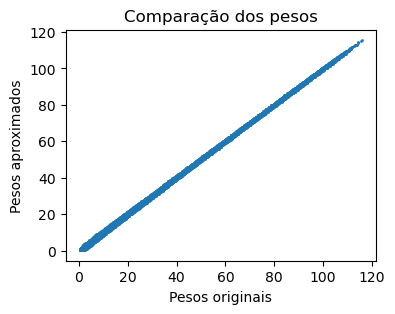

In [66]:
import matplotlib.pyplot as plt

U, S, V = torch.linalg.svd(delta_weights)

# Aproximação da matriz de pesos utilizando um subespaço de dimensão `rank`
rank = 2
A = S[:rank]*U[:, :rank]
B = V[:rank]

delta_weights_approx = A @ B

plt.scatter(delta_weights.flatten(), delta_weights_approx.flatten(), s=1)
plt.xlabel("Pesos originais")
plt.ylabel("Pesos aproximados")
plt.title("Comparação dos pesos")

In [67]:
print(weights_tuned.shape, A.shape, B.shape)

torch.Size([500, 500]) torch.Size([500, 2]) torch.Size([2, 500])


Portanto, os pesos refinados podem ser escritos como:

In [68]:
weights_tunned_approx = weights + A@B

print_tensor("Pesos refinados:", weights_tuned)
print_tensor("\nAproximação dos pesos refinados:", weights_tunned_approx)

Pesos refinados::
tensor([[30.8778,  6.8560, 13.7701, 20.8789, 53.6016, 28.6116, 39.8990, 55.8736],
        [39.7091,  6.4848, 14.9711, 24.6620, 70.5781, 30.5044, 45.9103, 72.3525],
        [35.3618,  3.9190, 14.7634, 22.2599, 75.6303, 23.2517, 41.1261, 77.0293],
        [43.5545,  7.3873, 17.0924, 27.6478, 90.6992, 31.4841, 54.5752, 92.5970]])

Aproximação dos pesos refinados::
tensor([[30.7542,  6.8657, 13.6904, 20.7707, 53.6183, 28.6010, 39.8825, 55.8973],
        [39.8579,  6.5943, 14.9058, 24.4664, 70.7019, 30.3698, 46.1782, 72.3616],
        [35.4189,  3.8739, 14.7981, 22.1249, 75.6902, 23.1462, 41.3680, 77.1529],
        [43.5485,  7.5121, 17.1630, 27.7505, 90.6667, 31.4690, 54.7331, 92.3792]])


Ao invés de refinar a matriz `weights` possuindo $500*500 = 250000$ valores, podemos refinar as matrizes `A` e `B` possuindo $1000$ elementos cada. Em geral, ao invés de refinar uma matriz possuindo $n*m$ parâmetros, podemos refinar duas matrizes com um total de $n*r + m*r$ parâmetros. Se $m=n$, temos uma redução de $n/2r$ no número de parâmetros.

Por exemplo, as matrizes das camadas de atenção do modelo Llama 3 70B possuem tamanho $8192\times 8192$. Um valor comum para o rank é 8. Com isso, ao invés de otimizar 67108864 parâmetros, a técnica LoRA permite otimizar apenas $2*8192*8=131072$ parâmetros. Uma redução de $\times 500$ no número de parâmetros. Isso também reduz drasticamente o uso de memória.

Uma outra vantagem do LoRA é que ela permite que modelos refinados em diferentes tarefas sejam rapidamente aplicados. O modelo base é mantido na memória, e apenas os parâmetros extra específicos de uma tarefa são trocados. Isso também permite compartilhar com a comunidade os parâmetros refinados com menor custo. 

### Acúmulo de gradientes

O acúmulo de gradientes consiste em *simular* um valor de batch size utilizando batches menores. Ele é útil quando queremos reproduzir o mesmo batch size utilizado em um artigo mas a GPU não possui memória suficiente para tal.

Suponha que a VRAM disponível suporta no máximo um batch size de 8 imagens. No exemplo abaixo, o treinamento terá um batch size efetivo de tamanho 32:

```python
gradient_accumulation_steps = 4
for step, (imgs, targets) in enumerate(dl_train):
    scores = model(imgs)
    loss(scores, targets)
    loss.backward()

    if (step+1)%gradient_accumulation_steps == 0:
        # Dá um passo após `gradient_accumulation_steps` batches
        optimizer.step()
        optimizer.zero_grad()

```

### Compilação do grafo de execução

Cada operação realizada pelo Pytorch na GPU envolve a chamada de uma função cuda. Isso representa um custo adicional de comunicação entre CPU e GPU. Adicionalmente, existem diversas operações que podem ser otimizadas. Por exemplo, uma operação de convolução seguida de uma operação batchnorm pode ser representada por uma única operação linear dado que ambas as operações são lineares. Um loop de treinamento envolve chamar exatamente as mesma funções diversas vezes. O Pytorch permite compilar um grafo de executação que otimizará uma sequência de operações realizadas na GPU. Isso é feito através da função `torch.compile()`. Por exemplo, dado um modelo, podemos fazer:

`model = torch.compile(model, fullgraph=True, dynamic=False)`

O modelo pode então ser utilizado no loop de treinamento. Isso pode levar a speedups significativos. Mas há restrições nos tipos de modelos que podem ser compilados.